<a href="https://colab.research.google.com/github/yossilevii100/double-ellipsoid-clip/blob/main/Double-Ellipsoid-Clip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openai-clip ftfy regex tqdm umap-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.0 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=07bf56ab919fb1273dce44fa2af6f88cb6af0857e17ae2bf095e2f7b517c7dae
  Stored in directory: /root/.cache/pip/wheels/0d/17/90/042948fd2e2a87f1dcf6db6d438cad015c49db0c53d1d9c7dc
Successfully built openai-clip


In [2]:
import os
import json
import random
import urllib.request
import zipfile
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import clip
import umap


In [3]:
os.makedirs("coco/samples", exist_ok=True)

ann_url = "http://images.cocodataset.org/annotations/annotations_trainval2014.zip"
ann_zip = "coco/annotations_trainval2014.zip"

if not os.path.exists(ann_zip):
    urllib.request.urlretrieve(ann_url, ann_zip)
    with zipfile.ZipFile(ann_zip, 'r') as zip_ref:
        zip_ref.extractall("coco/")

# Load captions
with open("coco/annotations/captions_val2014.json", "r") as f:
    captions_data = json.load(f)

images = captions_data["images"]
sampled_images = random.sample(images, 128)

# Download images
base_url = "http://images.cocodataset.org/val2014/"
for img in tqdm(sampled_images):
    url = base_url + img["file_name"]
    out_path = os.path.join("coco/samples", img["file_name"])
    if not os.path.exists(out_path):
        urllib.request.urlretrieve(url, out_path)

# One caption per image
id_to_caption = {}
for ann in captions_data["annotations"]:
    img_id = ann["image_id"]
    if img_id not in id_to_caption:
        id_to_caption[img_id] = ann["caption"]

sampled_meta = [{"file_name": img["file_name"], "image_id": img["id"], "caption": id_to_caption.get(img["id"], "")} for img in sampled_images]

with open("coco/sampled_metadata.json", "w") as f:
    json.dump(sampled_meta, f, indent=2)

print("✅ Download complete. Example:", sampled_meta[0])


100%|██████████| 128/128 [02:39<00:00,  1.25s/it]

✅ Download complete. Example: {'file_name': 'COCO_val2014_000000275279.jpg', 'image_id': 275279, 'caption': 'This bathroom features a marble top vanity with double sinks.'}


Let us recall the Modality Gap phenomenon by plotting a 2D UMAP of the 128 samples of MSCOCO.

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image_features = []
text_features = []

for entry in tqdm(sampled_meta):
    img_path = os.path.join("coco/samples", entry["file_name"])
    image = preprocess(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)

    with torch.no_grad():
        img_feat = model.encode_image(image).cpu().numpy().squeeze()

    text = clip.tokenize([entry["caption"]]).to(device)

    with torch.no_grad():
        txt_feat = model.encode_text(text).cpu().numpy().squeeze()

    image_features.append(img_feat)
    text_features.append(txt_feat)

image_features = np.stack(image_features)
text_features = np.stack(text_features)

print("✅ Feature matrices shape:", image_features.shape, text_features.shape)

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 115MiB/s]
100%|██████████| 128/128 [00:07<00:00, 16.63it/s]

✅ Feature matrices shape: (128, 512) (128, 512)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


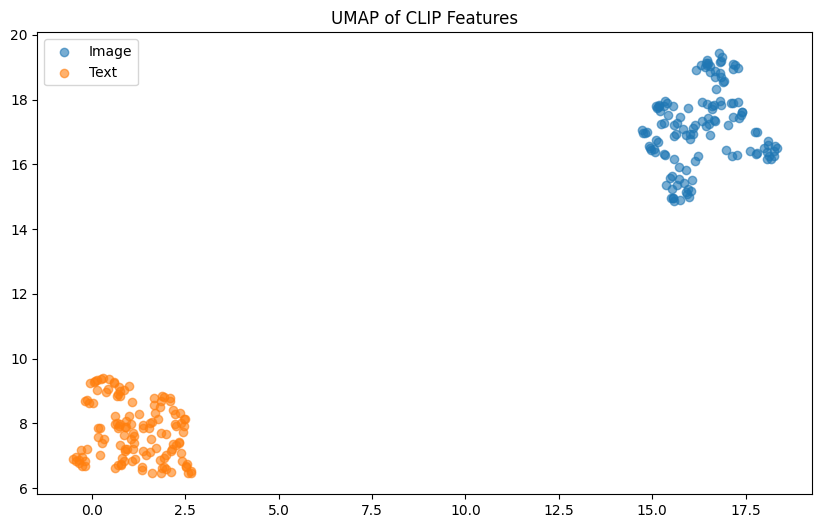

In [5]:
features = np.concatenate([image_features, text_features], axis=0)
labels = ["image"] * len(image_features) + ["text"] * len(text_features)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding = reducer.fit_transform(features)

plt.figure(figsize=(10, 6))
plt.scatter(embedding[:128, 0], embedding[:128, 1], label="Image", alpha=0.6)
plt.scatter(embedding[128:, 0], embedding[128:, 1], label="Text", alpha=0.6)
plt.legend()
plt.title("UMAP of CLIP Features")
plt.show()

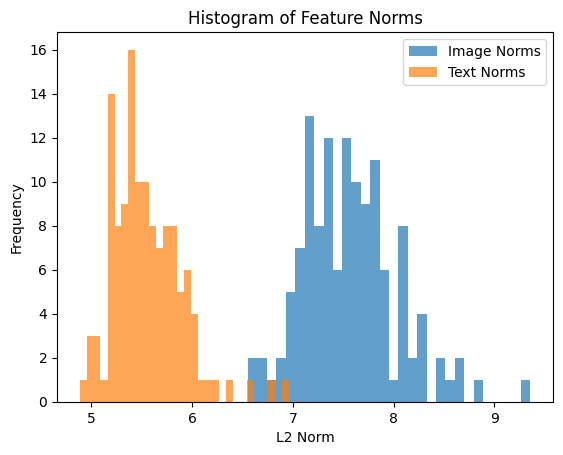

In [7]:
image_norms = np.linalg.norm(image_features-np.mean(image_features, axis=0), axis=1)
text_norms = np.linalg.norm(text_features-np.mean(text_features, axis=0), axis=1)

plt.hist(image_norms, bins=30, alpha=0.7, label="Image Norms")
plt.hist(text_norms, bins=30, alpha=0.7, label="Text Norms")
plt.title("Histogram of Feature Norms")
plt.xlabel("L2 Norm")
plt.ylabel("Frequency")
plt.legend()
plt.show()


As can be seen there is no energy near zero, therefore a thin-shell phenomenon where all samples are distributed in a thin shell of the tllipsoid.

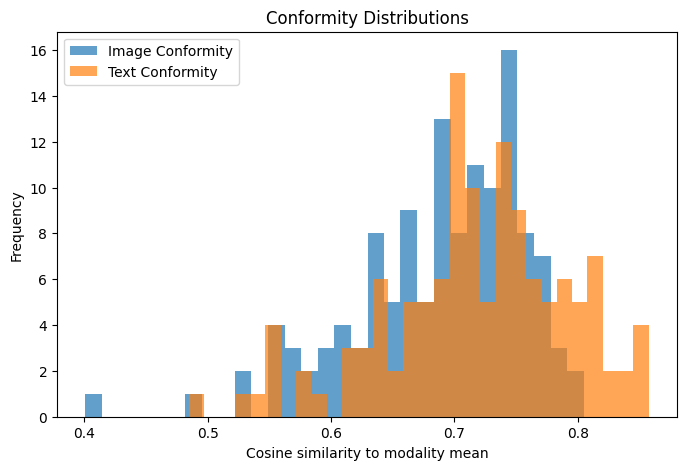

🟢 Top-5 High Conformity Images:


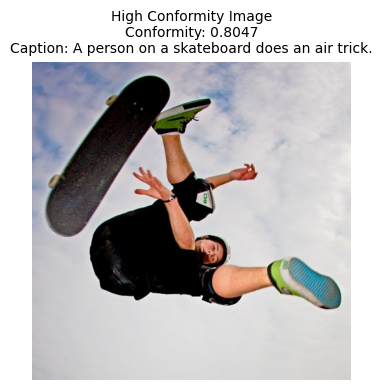

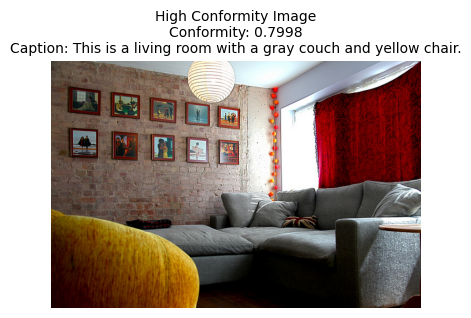

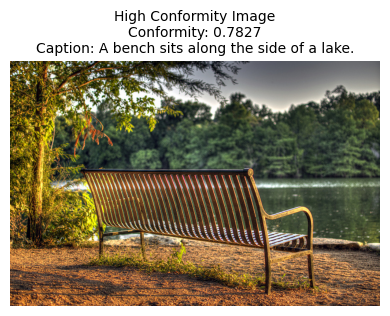

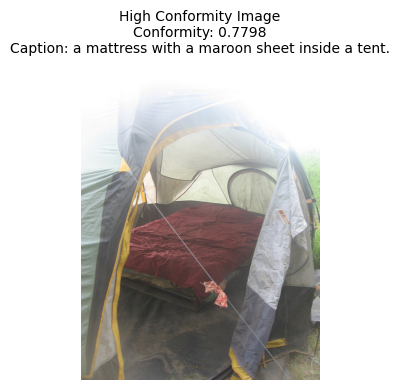

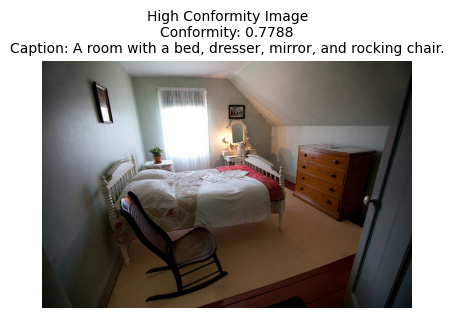

🔴 Bottom-5 Low Conformity Images:


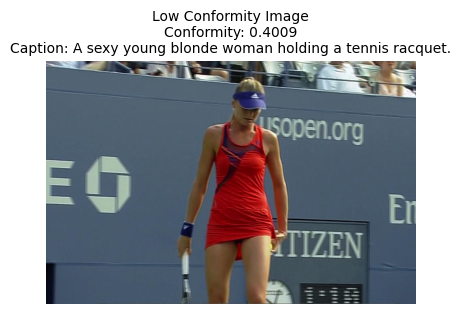

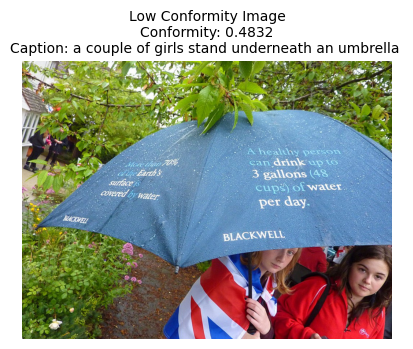

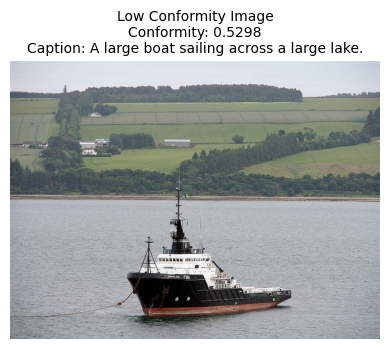

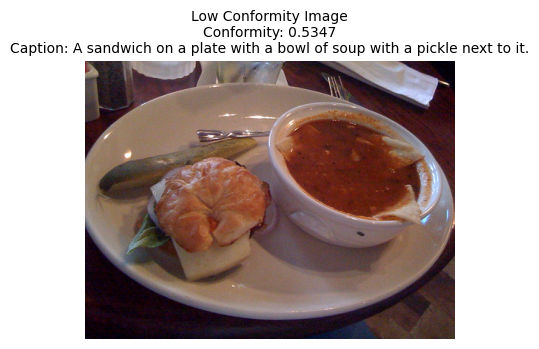

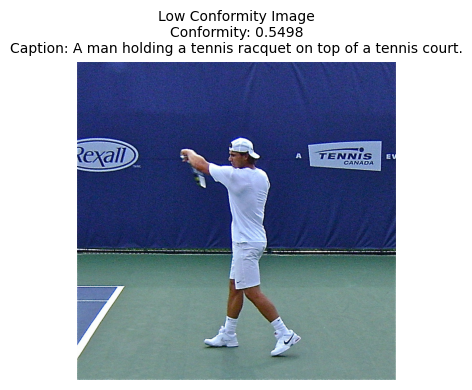

In [12]:
# Compute conformity for images
def compute_conformity(feats):
    feats_norm = feats / np.linalg.norm(feats, axis=1, keepdims=True)
    mean_dir = feats_norm.mean(axis=0)
    mean_dir /= np.linalg.norm(mean_dir)
    conformity = feats_norm @ mean_dir
    return conformity

# Compute conformity scores for both modalities
conformity_img = compute_conformity(image_features)
conformity_txt = compute_conformity(text_features)

# Plot distributions of conformity
plt.figure(figsize=(8, 5))
plt.hist(conformity_img, bins=30, alpha=0.7, label="Image Conformity")
plt.hist(conformity_txt, bins=30, alpha=0.7, label="Text Conformity")
plt.title("Conformity Distributions")
plt.xlabel("Cosine similarity to modality mean")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Visualize top-5 and bottom-5 conformity images
top5_img = np.argsort(conformity_img)[-5:][::-1]
bottom5_img = np.argsort(conformity_img)[:5]

# Function to plot image along with its conformity and caption
def plot_image(idx, title):
    img_path = os.path.join("coco/samples", sampled_meta[idx]["file_name"])
    img = Image.open(img_path)
    caption = sampled_meta[idx]["caption"]
    conf = conformity_img[idx]

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{title}\nConformity: {conf:.4f}\nCaption: {caption}", fontsize=10)
    plt.tight_layout()
    plt.show()

# Plot the top-5 high conformity images
print("🟢 Top-5 High Conformity Images:")
for idx in top5_img:
    plot_image(idx, "High Conformity Image")

# Plot the bottom-5 low conformity images
print("🔴 Bottom-5 Low Conformity Images:")
for idx in bottom5_img:
    plot_image(idx, "Low Conformity Image")


In [11]:
# Get top-5 and bottom-5 indices for text conformity
top5_txt = np.argsort(conformity_txt)[-5:][::-1]
bottom5_txt = np.argsort(conformity_txt)[:5]

print("🟢 Top-5 High Conformity Captions:\n")
for idx in top5_txt:
    print(f"  • {sampled_meta[idx]['caption']} (conformity: {conformity_txt[idx]:.4f})")

print("\n🔴 Bottom-5 Low Conformity Captions:\n")
for idx in bottom5_txt:
    print(f"  • {sampled_meta[idx]['caption']} (conformity: {conformity_txt[idx]:.4f})")

🟢 Top-5 High Conformity Captions:

  • a small boat in a body of water  (conformity: 0.8574)
  • a person that is on a black skateboard (conformity: 0.8564)
  • A batter has just attempted to hit the ball being pitched to him while waiting at home plate. (conformity: 0.8477)
  • A man in the kitchen is doing his job.  (conformity: 0.8452)
  • A man dressed up and posing for a picture (conformity: 0.8364)

🔴 Bottom-5 Low Conformity Captions:

  • A small dog wearing a pink and purple dress. (conformity: 0.4849)
  • A black and white cat sitting in front of a black bag. (conformity: 0.5278)
  • A bathroom sink with a marble counter top under a large mirror. (conformity: 0.5400)
  • A sheepdog runs around a herd of cows in a fenced-in field. (conformity: 0.5479)
  • A man standing behind a truck with a red trailer sitting in front of a building. (conformity: 0.5537)
